# 04 | Final Evaluation

This notebook summarises the final evaluation of the best-performing credit risk model for the LoanVet project.

We assess model performance on the holdout test set, including key metrics, visualisations, error analysis, and interpretability using SHAP.

The goal is to provide a clear and comprehensive view of model quality before deployment.

## Load Final Model & Data

In [15]:
import os
import json
import joblib
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

import shap

sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)

# Load engineered dataset from SQLite
conn = sqlite3.connect("../data/loanvet.db")
df = pd.read_sql_query("SELECT * FROM credit_risk_engineered", conn)
conn.close()

# Drop redundant columns (same as training notebook)
drop_cols = [
    "RevolvingUtilizationOfUnsecuredLines",
    "DebtRatio",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate",
    "NumberOfTime60-89DaysPastDueNotWorse",
    'NumberOfTime30-59DaysPastDueNotWorse_log',
    'NumberOfTimes90DaysLate_log',
    'NumberOfTime60-89DaysPastDueNotWorse_log',
    "TotalDelinquencies",
    "MonthlyIncome"
]
df = df.drop(columns=drop_cols, errors='ignore')

# Load features and target
feature_list_path = "../models/advanced/feature_list.json"
with open(feature_list_path, "r") as f:
    feature_list = json.load(f)

X = df[feature_list]
y = df["SeriousDlqin2yrs"]

# Load final tuned model (XGBoost) and threshold
model_path = "../models/final/xgb_final_model.joblib"
xgb_final_model = joblib.load(model_path)

optimal_threshold = 0.2268

# Split into train/test same as before for reproducibility
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## Performance Metrics

In [16]:
def evaluate_model(name, model, X_test, y_test, threshold=0.5):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    roc_auc = roc_auc_score(y_test, y_probs)
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Evaluation (Threshold={threshold}):")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC:  {pr_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "f1": f1,
        "confusion_matrix": cm,
        "y_pred": y_pred,
        "y_probs": y_probs
    }

final_results = evaluate_model("XGBoost", xgb_final_model, X_test, y_test, threshold=optimal_threshold)



XGBoost Evaluation (Threshold=0.2268):
ROC-AUC: 0.8643
PR-AUC:  0.4038
F1 Score: 0.4589
Confusion Matrix:
[[26521  1356]
 [ 1002  1000]]


## Visualisations

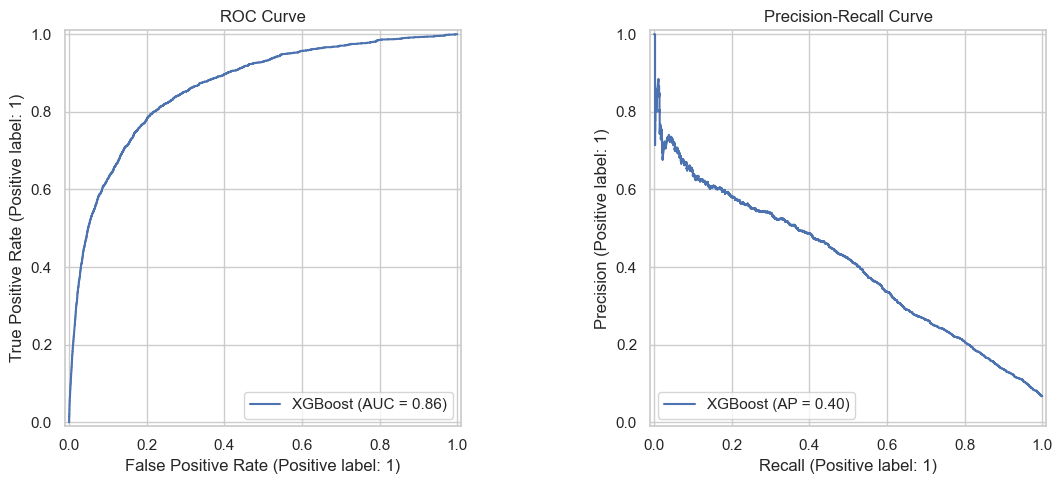

In [17]:
# ROC Curve

y_probs = final_results['y_probs']

plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, y_probs, name="XGBoost", ax=ax1)
ax1.set_title("ROC Curve")

ax2 = plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, y_probs, name="XGBoost", ax=ax2)
ax2.set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()


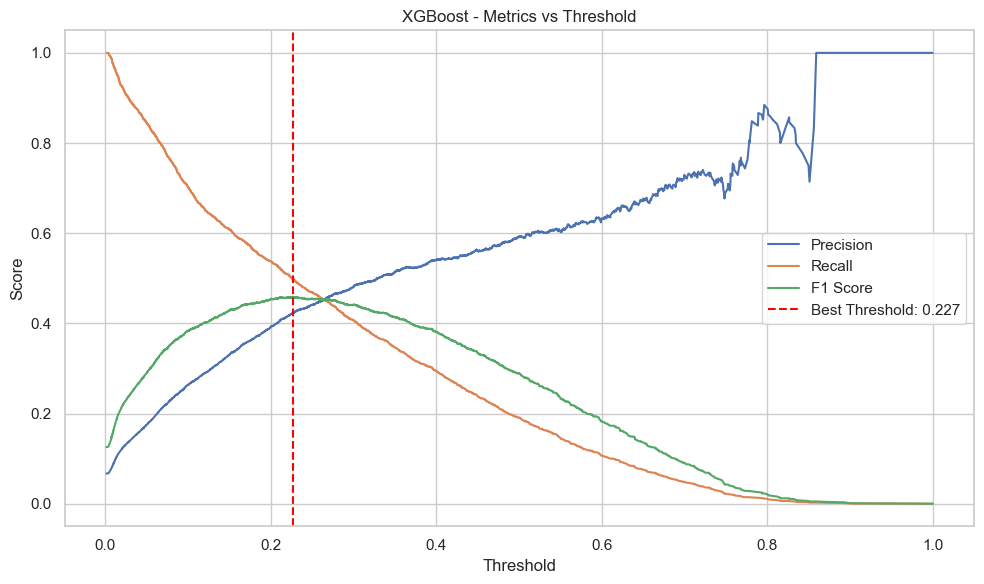

XGBoost Best Threshold: 0.2268
F1: 0.4589, Precision: 0.4244, Recall: 0.4995


In [18]:
# Threshold tuning plots (precision, recall, F1)
def plot_threshold_metrics(y_true, y_probs, model_name):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    thresholds = np.append(thresholds, 1.0)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision, label="Precision")
    plt.plot(thresholds, recall, label="Recall")
    plt.plot(thresholds, f1_scores, label="F1 Score")
    plt.axvline(best_threshold, linestyle='--', color='red', label=f"Best Threshold: {best_threshold:.3f}")
    plt.title(f"{model_name} - Metrics vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{model_name} Best Threshold: {best_threshold:.4f}")
    print(f"F1: {f1_scores[best_idx]:.4f}, Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}")

plot_threshold_metrics(y_test, y_probs, "XGBoost")

## Error Analysis

ErrorType
True Negative (TN)     26521
False Positive (FP)     1356
False Negative (FN)     1002
True Positive (TP)      1000
Name: count, dtype: int64


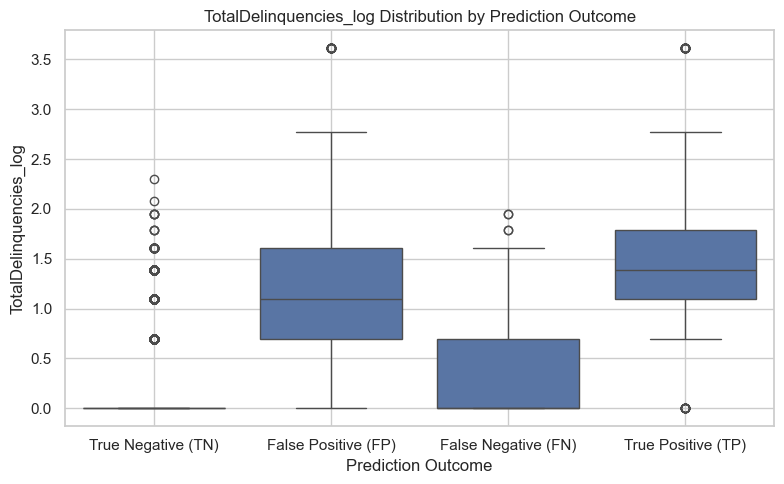

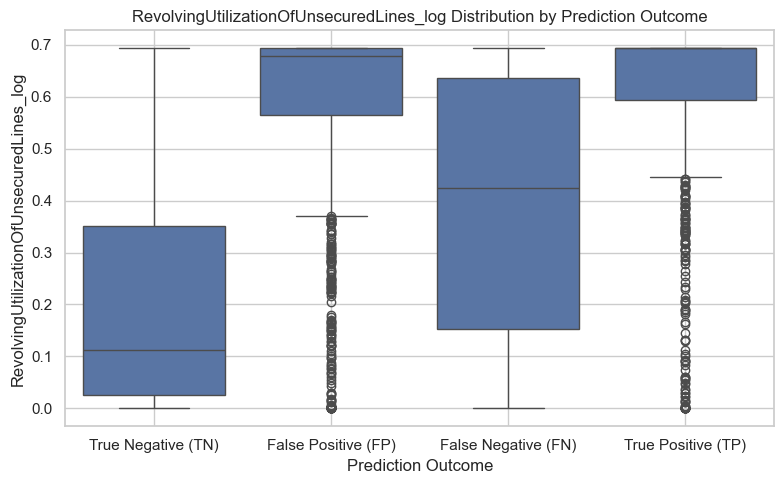

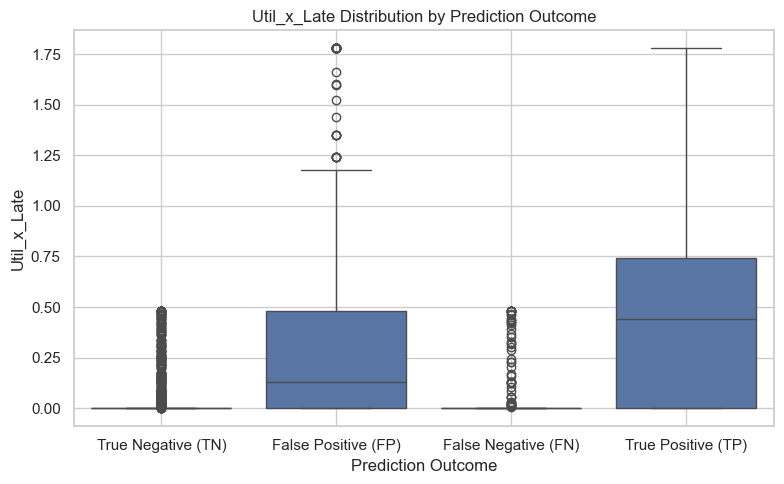

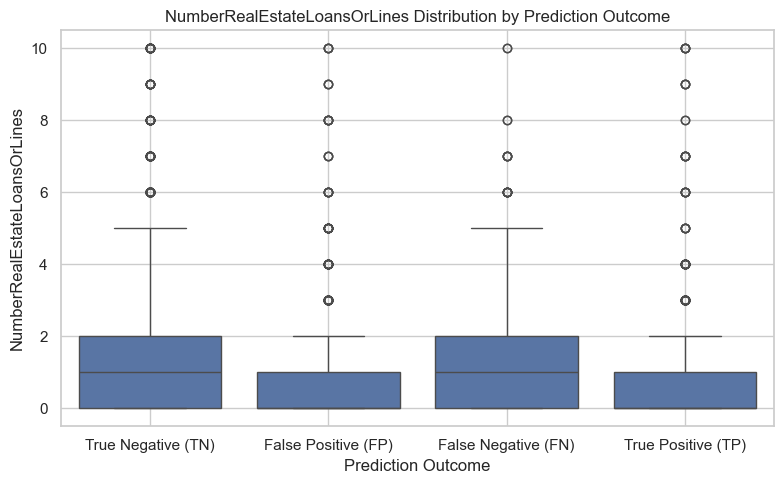

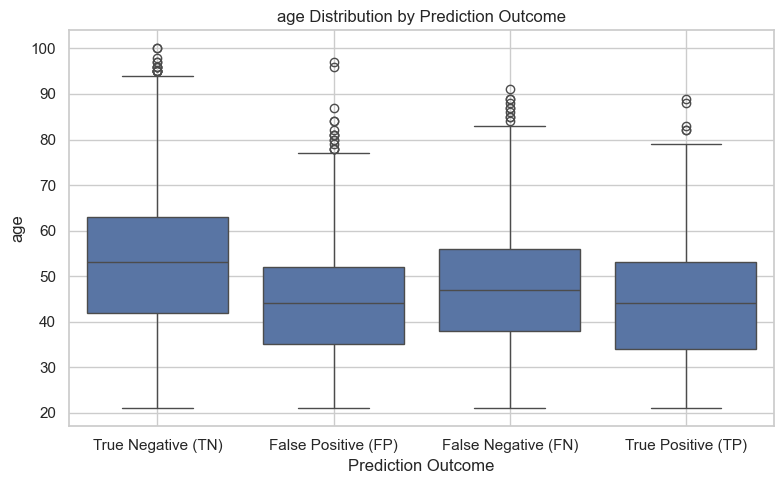

In [19]:
# Create a DataFrame for error analysis
analysis_df = X_test.copy()
analysis_df["Actual"] = y_test.values
analysis_df["Predicted"] = final_results["y_pred"]
analysis_df["Probability"] = final_results["y_probs"]

def get_error_type(row):
    if row["Actual"] == 1 and row["Predicted"] == 1:
        return "True Positive (TP)"
    elif row["Actual"] == 0 and row["Predicted"] == 0:
        return "True Negative (TN)"
    elif row["Actual"] == 0 and row["Predicted"] == 1:
        return "False Positive (FP)"
    else:
        return "False Negative (FN)"

analysis_df["ErrorType"] = analysis_df.apply(get_error_type, axis=1)

print(analysis_df["ErrorType"].value_counts())

# Plot top 5 important features distributions across error types
top_features = ['TotalDelinquencies_log', 'RevolvingUtilizationOfUnsecuredLines_log',
                'Util_x_Late', 'NumberRealEstateLoansOrLines', 'age']

import matplotlib.pyplot as plt
import seaborn as sns

for feature in top_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="ErrorType", y=feature, data=analysis_df,
                order=["True Negative (TN)", "False Positive (FP)", "False Negative (FN)", "True Positive (TP)"])
    plt.title(f"{feature} Distribution by Prediction Outcome")
    plt.xlabel("Prediction Outcome")
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Model Interpretability (SHAP)

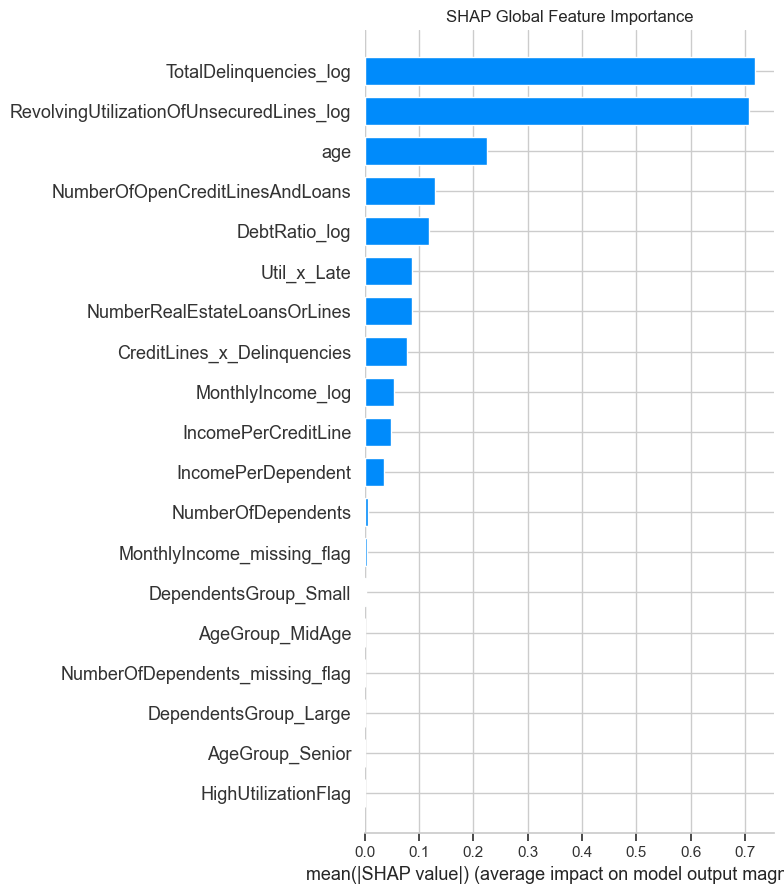

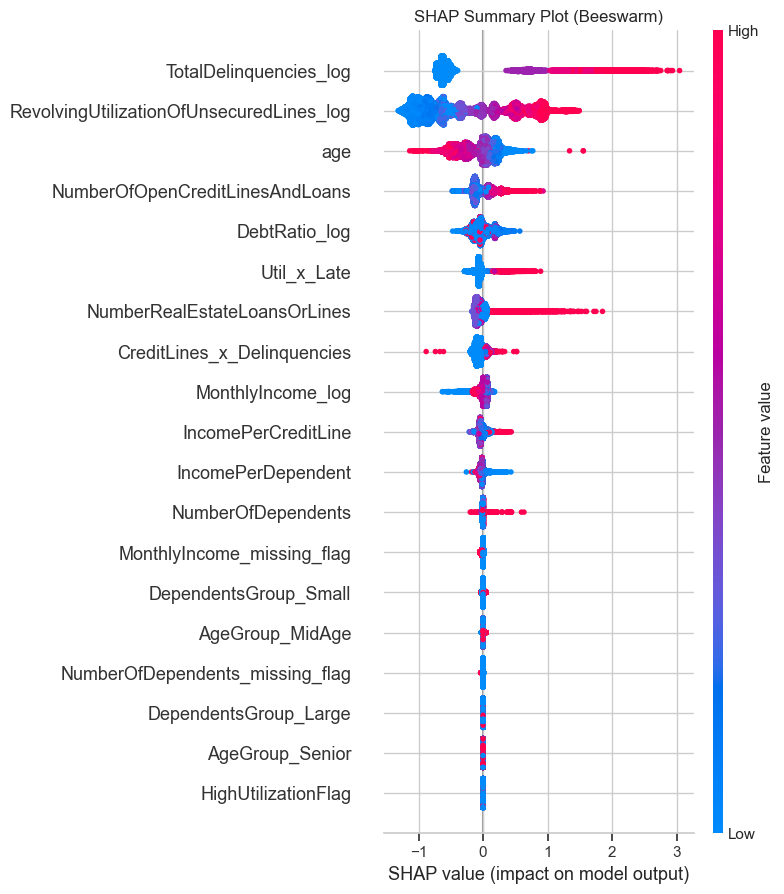

In [20]:
explainer = shap.Explainer(xgb_final_model)
shap_values = explainer(X_test)

# Global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance")
plt.tight_layout()
plt.show()

# SHAP summary beeswarm
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot (Beeswarm)")
plt.tight_layout()
plt.show()

True Positive index: 34


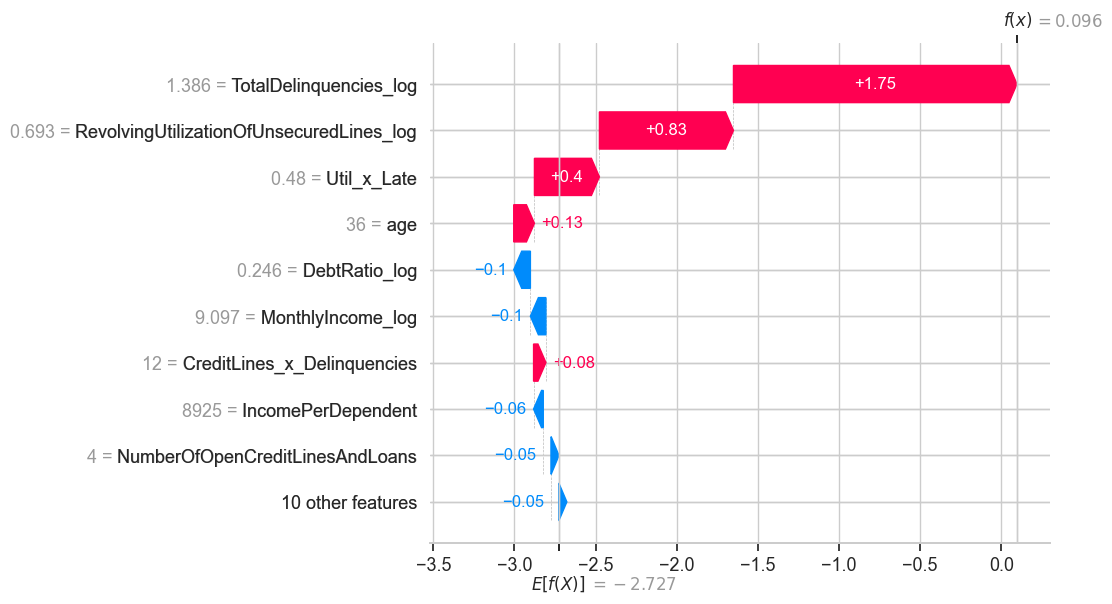

False Negative index: 7


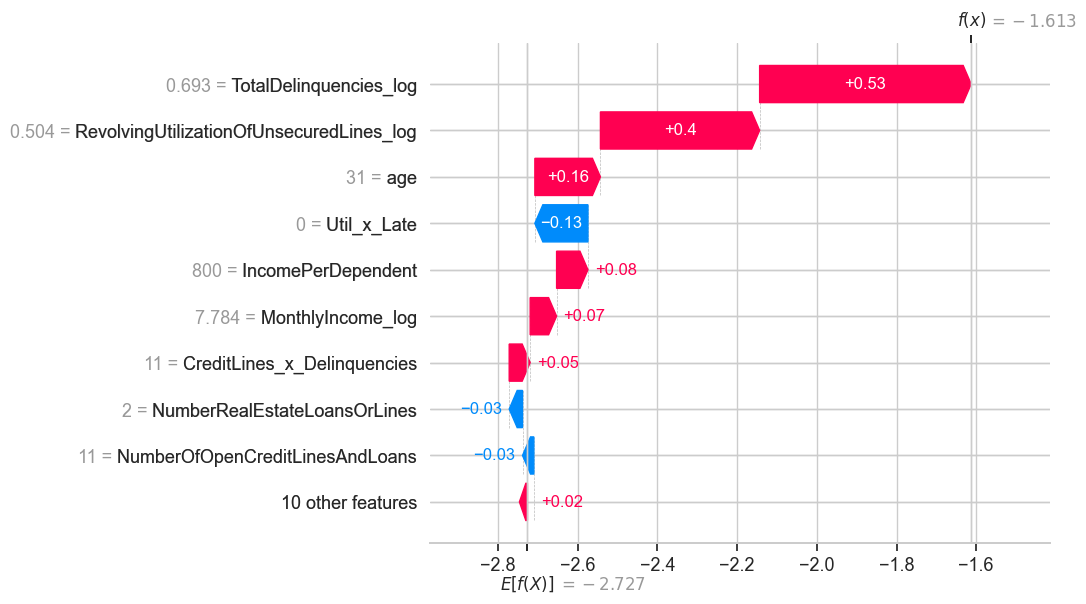

In [21]:
# Local explanation example: true positive and false negative waterfall plots

y_probs = final_results["y_probs"]
y_pred = final_results["y_pred"]

tp_index = np.where((y_test == 1) & (y_pred == 1))[0][0]
fn_index = np.where((y_test == 1) & (y_pred == 0))[0][0]

shap.initjs()

print(f"True Positive index: {tp_index}")
shap.plots.waterfall(shap_values[tp_index])

print(f"False Negative index: {fn_index}")
shap.plots.waterfall(shap_values[fn_index])

## Conclusion

- The final tuned XGBoost model demonstrates strong predictive performance with ROC-AUC of ~0.86 and balanced precision-recall metrics after threshold tuning.
- Error analysis highlights typical patterns of misclassification, which can inform future feature engineering or policy adjustments.
- SHAP interpretability confirms the model aligns with domain expectations, with delinquency history and credit utilization as dominant risk drivers.
- Next steps include deploying this model in a production environment, integrating it with an API or dashboard for real-time credit risk scoring.
- Continuous monitoring and periodic retraining will be critical to maintain model accuracy over time.